### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

### Prepare Dataframe

In [3]:
IMAGE_SIZE = (150,150)
INPUT_SHAPE = (150,150,3)
TRAIN_FILEPATH = "dogs-vs-cats/train/train"
BATCH_SIZE=16

TEST_FILEPATH = "dogs-vs-cats/test1/test1"

In [4]:
#train dataset
import os
train_filenames = os.listdir(TRAIN_FILEPATH)
train_dict = {}

for filename in train_filenames:
    if "dog" in filename:
        train_dict[filename] = 1
    else:
        train_dict[filename] = 0

train_df = pd.DataFrame(train_dict.items(),
                                 columns=['filename' ,'Dog'])
train_df.head(12510)

,filename,Dog
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
12505,dog.10000.jpg,1
12506,dog.10001.jpg,1
12507,dog.10002.jpg,1
12508,dog.10003.jpg,1


In [5]:
train_df["Dog"].replace({0:"cat", 1:"dog"}, inplace=True)
train_df.head(12510)

,filename,Dog
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat
...,...,...
12505,dog.10000.jpg,dog
12506,dog.10001.jpg,dog
12507,dog.10002.jpg,dog
12508,dog.10003.jpg,dog


<AxesSubplot:>

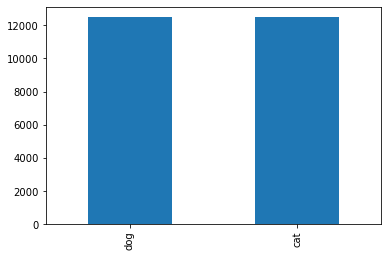

In [6]:
#analyse the data
train_df.Dog.value_counts().plot.bar()

In [7]:
#split into train and test sets
from sklearn.model_selection import train_test_split

training_df, validation_df = train_test_split(train_df, 
                                              test_size=0.2,
                                             random_state=1)

print("training_df shape: ", training_df.shape)
print("validation_df shape: ", validation_df.shape)

training_df shape:  (20000, 2)
validation_df shape:  (5000, 2)


In [8]:
#augmentation configuration for training
train_datagen = ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

#augmentation example for one image
img = load_img("dogs-vs-cats/train/train/cat.0.jpg")
x = img_to_array(img) #numpy array with shape (3, 150, 150)
x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the 'preview/' directory

i=0
for batch in train_datagen.flow(x, batch_size=1,
                               save_to_dir="dogs-vs-cats/preview",
                               save_prefix="cat",
                               save_format="jpg"):
    i += 1
    if i > 20:
        break #otherwise the generator would loop indefinitely


In [9]:
"""
this is a generator that will read pictures found in subfolders of "dogs-vs-cats/train/train", and will
indefinitely generate batches of augmented image data
"""
train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory=TRAIN_FILEPATH,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    x_col="filename",
    y_col="Dog",
    class_mode = "categorical" #binary, categorical, sparse, input, None, raw
)

#augmentation configuration used for testing. only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

#this is for validation data
validation_generator = test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=TRAIN_FILEPATH,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    x_col="filename",
    y_col="Dog",
    class_mode = "categorical"
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


### Build CNN Model

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model=Sequential()

model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=INPUT_SHAPE))
model.add(Conv2D(64, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=3, activation="relu"))
model.add(Conv2D(256, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(2, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 256)       0

### Callbacks

In [11]:
from keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(monitor="val_loss",
                         min_delta=0.001,
                         patience=5,
                         restore_best_weights=True)

### Fit the model

In [16]:
history = model.fit(train_generator,
         batch_size=BATCH_SIZE,
         epochs=50,
         verbose=1,
         validation_data=validation_generator,
         callbacks=earlyStop)

Epoch 1/50
1250/1250 [==============================] - 973s 779ms/step - loss: 0.5306 - accuracy: 0.7512 - val_loss: 0.6186 - val_accuracy: 0.7558
Epoch 2/50
1250/1250 [==============================] - 993s 794ms/step - loss: 0.5345 - accuracy: 0.7518 - val_loss: 0.4647 - val_accuracy: 0.7994
Epoch 3/50
1250/1250 [==============================] - 999s 799ms/step - loss: 0.5606 - accuracy: 0.7476 - val_loss: 0.5602 - val_accuracy: 0.6946
Epoch 4/50
1250/1250 [==============================] - 996s 796ms/step - loss: 0.5945 - accuracy: 0.7284 - val_loss: 0.9528 - val_accuracy: 0.6714
Epoch 5/50
1250/1250 [==============================] - 988s 790ms/step - loss: 0.6557 - accuracy: 0.6995 - val_loss: 0.5939 - val_accuracy: 0.7012
Epoch 6/50
1250/1250 [==============================] - 991s 793ms/step - loss: 0.6956 - accuracy: 0.6704 - val_loss: 0.5773 - val_accuracy: 0.7254
Epoch 7/50
1250/1250 [==============================] - 984s 787ms/step - loss: 0.7368 - accuracy: 0.6196 - val_

### Training model history

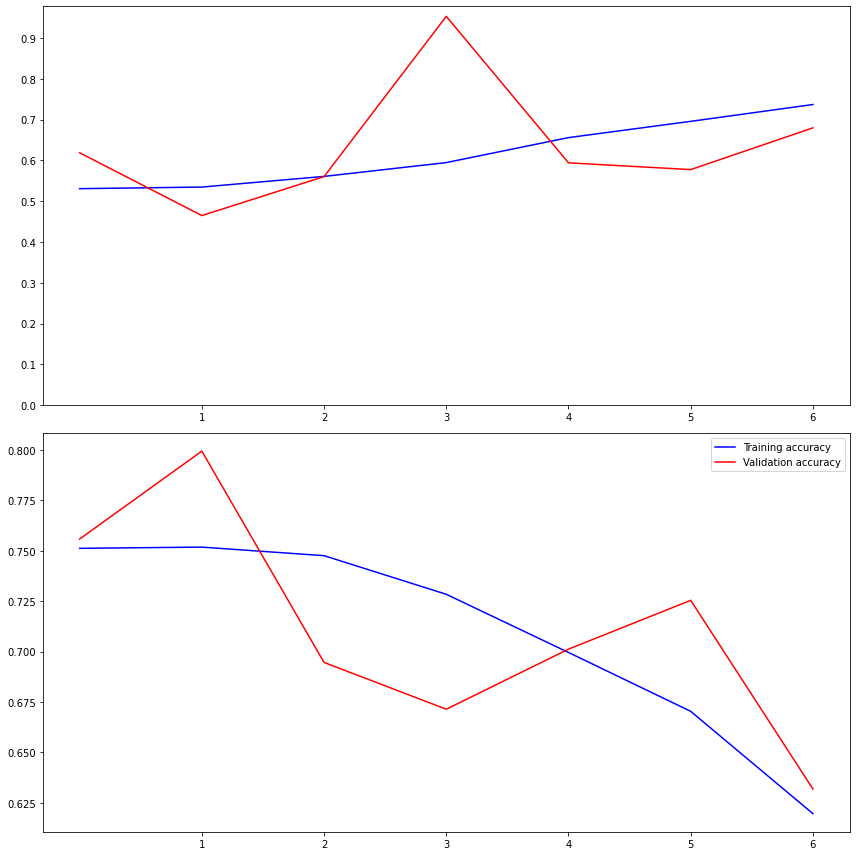

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training Loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation Loss")
ax1.set_xticks(np.arange(1, 7, 1))
ax1.set_yticks(np.arange(0,1,0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, 7, 1))

plt.legend()
plt.tight_layout()
plt.show()